Dataset: [Customer Personality Analysis](https://drive.google.com/file/d/19TUlAkMBRQi4MKfimeYBxCrFSeYk0ZGr/view?usp=sharing)

## Importing Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import warnings
import inflection

from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 5)
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from tqdm.auto import tqdm

nK = 10
SEED = 10

COLOR = '#319DA0'

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')



def load_dataset(path):
    df = pd.read_csv(path)
    return df

# Task 1 - Conversion Rate Analysis Based on Income, Spending and Age

**Tahapan Pengerjaan**
1. Download file 'Dataset'
2. Melakukan feature engineering: conversion rate
3. Menghitung dan mengelompokkan 'umur' menjadi ke beberapa kelompok
4. Buatlah plot yang dapat menunjukkan hubungan antara conversion rate dan jenis user yang berpotensi lebih besar untuk merespon campaign
5. Interpretasi plot tersebut dan perhatikan, Apakah terdapat hubungan yang signifikan antara umur customer dengan conversion rate

In [14]:
df = load_dataset('marketing_campaign_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0


I will convert column names into snake_case format. It's just a personal preference.

In [15]:
# renaming the column
column_list = list(df.columns)

for i, col in enumerate(column_list):
    column_list[i] = inflection.underscore(column_list[i]).replace(' ', '_')

df.columns = column_list
df.head()

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response
0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Feature Engineering

In [16]:
def preparation(df):

    df['dt_customer'] = pd.to_datetime(df['dt_customer'])

    df['age'] = df['year_birth'].apply(lambda x: 2022 - x)
    df.insert(2, 'age', df.pop('age'))
    
    df['join_at_age'] = df['dt_customer'].dt.year - df['year_birth']
    df['total_children'] = df['kidhome'] + df['teenhome']
    df['is_parents'] = np.where(df['total_children'] > 0, 1, 0)
    
    # calculate total spent
    df['total_spent'] = df['mnt_coke'] + df['mnt_fruits'] + df['mnt_meat_products'] + df['mnt_fish_products'] + df['mnt_sweet_products'] + df['mnt_gold_prods']

    # calculate total accepted campaigns
    df['total_accepted_camp'] = df['accepted_cmp1'] + df['accepted_cmp2'] + df['accepted_cmp3'] + df['accepted_cmp4'] + df['accepted_cmp5']

    # total transaction purchased
    df['total_transaction'] = df['num_deals_purchases'] + df['num_web_purchases'] + df['num_catalog_purchases'] + df['num_store_purchases']
    
    # mapping age into 5 group
    def map_age(s):
        if s < 12:
            return 'child'
        elif s < 18:
            return 'teens'
        elif s < 36:
            return 'mature'
        elif s < 55:
            return 'middle_aged'
        else:
            return 'older_adults'
        
    df['map_age'] = df['age'].apply(map_age)
    df.insert(3, 'map_age', df.pop('map_age'))

    def cvr(x, y):
        if y == 0:
            return 0
        return x / y

    df['cvr'] = df.apply(lambda x: cvr(x['total_transaction'], x['num_web_visits_month']), axis=1)
    
    return df

df = preparation(df)
df.head()

,id,year_birth,age,map_age,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,join_at_age,total_children,is_parents,total_spent,total_accepted_camp,total_transaction,cvr
0,5524,1957,65,older_adults,S1,Lajang,58138000.0,0,0,2012-04-09,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1,55,0,0,1617000,0,25,3.571429
1,2174,1954,68,older_adults,S1,Lajang,46344000.0,1,1,2014-08-03,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0,60,2,1,27000,0,6,1.200000
2,4141,1965,57,older_adults,S1,Bertunangan,71613000.0,0,0,2013-08-21,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0,48,0,0,776000,0,21,5.250000
3,6182,1984,38,middle_aged,S1,Bertunangan,26646000.0,1,0,2014-10-02,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0,30,1,1,53000,0,8,1.333333
4,5324,1981,41,middle_aged,S3,Menikah,58293000.0,1,0,2014-01-19,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0,33,1,1,422000,0,19,3.800000


## Quick Exploratory Data Analysis Based on Income, Spending and Age

In [17]:
numerical = ['age', 'income', 'kidhome', 'teenhome', 'recency', 'mnt_coke', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 
             'mnt_sweet_products', 'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases',
             'num_store_purchases', 'num_web_visits_month', 'z_cost_contact', 'z_revenue', 'join_at_age', 'total_children', 'total_spent'
            ]

categorical = ['education', 'marital_status','accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3',
               'accepted_cmp4', 'accepted_cmp5', 'complain', 'response', 'is_parents', 'map_age'
              ]

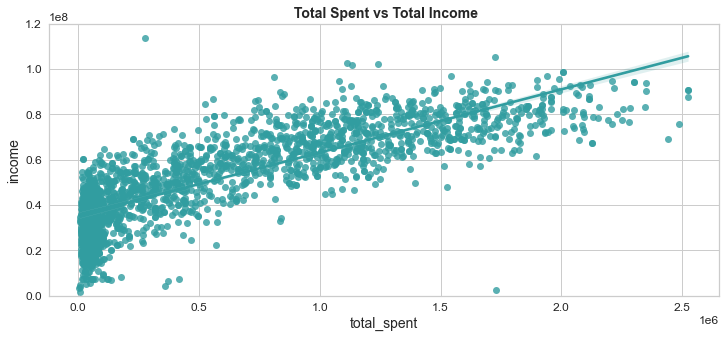

In [18]:
sns.regplot(x='total_spent', y='income', color=COLOR, data=df)
plt.title(' Total Spent vs Total Income', fontweight='bold')
plt.ylim(0, 120000000)
plt.show()

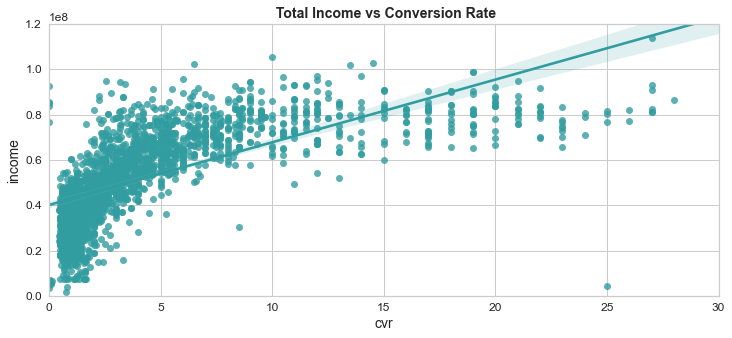

In [19]:
sns.regplot(x='cvr', y='income', color=COLOR, data=df)
plt.title(' Total Income vs Conversion Rate', fontweight='bold')
plt.xlim(0, 30)
plt.ylim(0, 120000000)
plt.show()

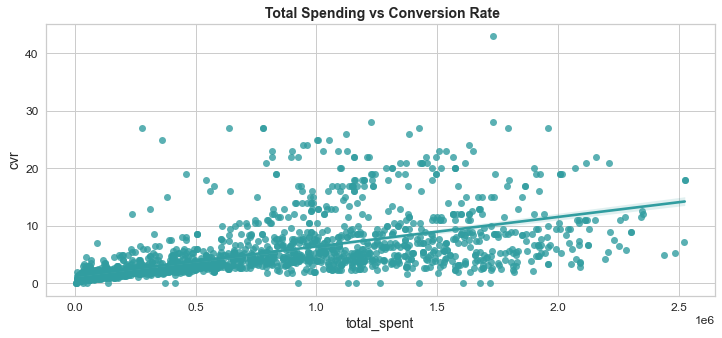

In [20]:
sns.regplot(x='total_spent', y='cvr', color=COLOR, data=df)
plt.title(' Total Spending vs Conversion Rate', fontweight='bold')
plt.show()

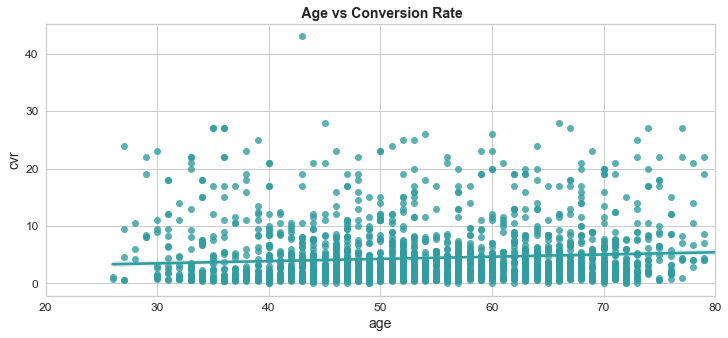

In [21]:
sns.regplot(x='age', y='cvr', color=COLOR, data=df)
plt.title(' Age vs Conversion Rate', fontweight='bold')
plt.xlim(20, 80)
plt.show()

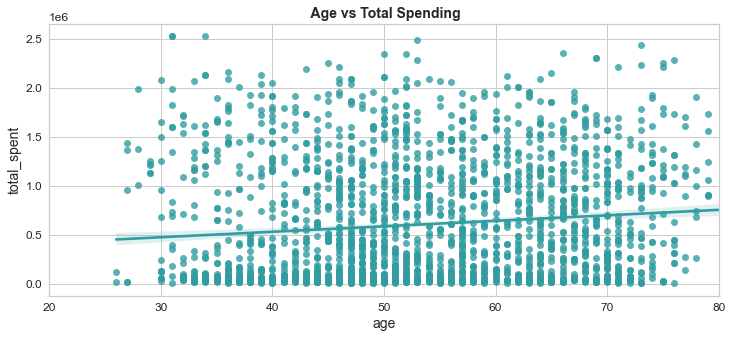

In [22]:
sns.regplot(x='age', y='total_spent', color=COLOR, data=df)
plt.title(' Age vs Total Spending', fontweight='bold')
plt.xlim(20, 80)
plt.show()

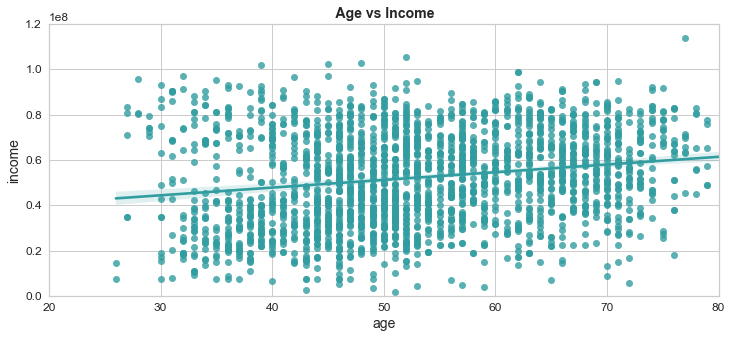

In [23]:
sns.regplot(x='age', y='income', color=COLOR, data=df)
plt.title(' Age vs Income', fontweight='bold')
plt.xlim(20, 80)
plt.ylim(0, 120000000)
plt.show()

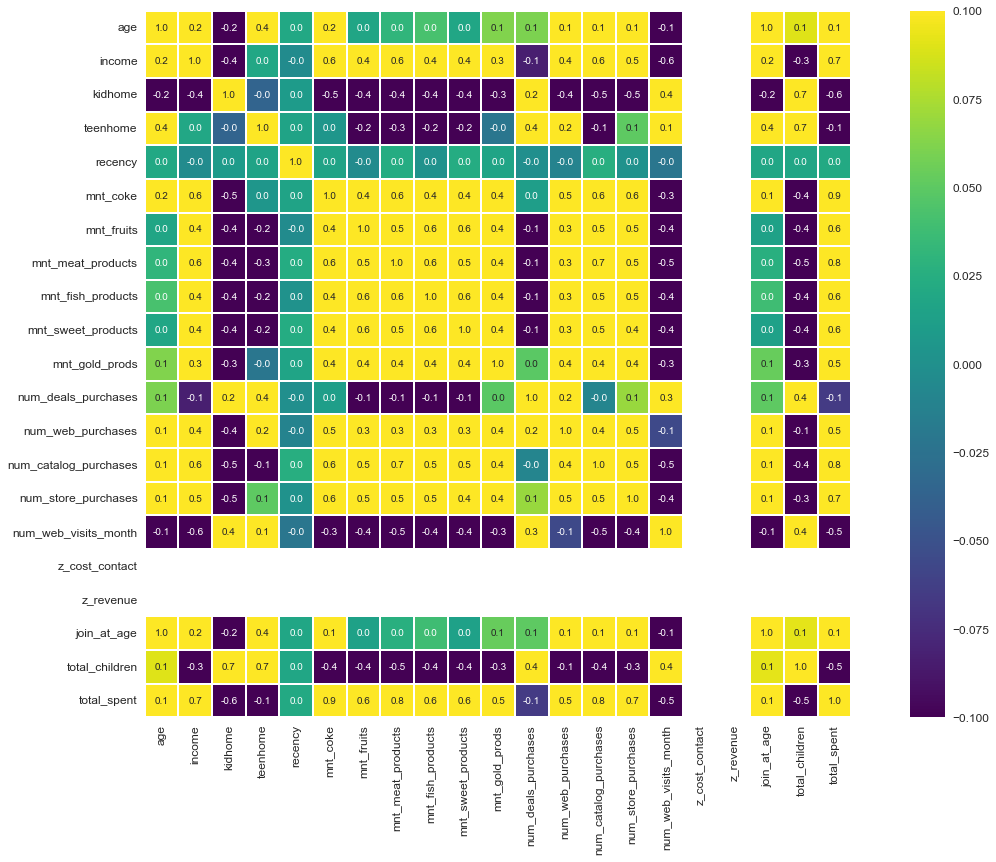

In [24]:
plt.figure(figsize=(21, 13))
corr = df[numerical].corr()
sns.heatmap(corr, annot=True, cbar=True, square=True, fmt='.1f',
           vmin=corr.values.min(), vmax=1, linewidth=0.1, cmap='viridis')
plt.show()

**Observation**
1. Highest income, highest spent
2. Highest income & spent has the potential to generate revenue
3. Age directly proportional with income and spent

# Task 2 - Data Cleaning & Preprocessing

**Tahapan Pengerjaan**
1. Mengatasi data null dan duplicated
2. Membuang data yang tidak diperlukan
3. Melakukan feature encoding
4. Melakukan standardisasi pada feature

## Handling Missing Value

In [25]:
total_null = pd.DataFrame(df.isna().sum()).T.rename({0:'total_null'})
percentage_null = pd.DataFrame(100 * df.isna().sum() / df.shape[0]).T.rename({0:'percentage_null'})
data_null = pd.concat([total_null, percentage_null]).T
mask = data_null['total_null'] != 0
data_null.loc[mask].sort_values('total_null', ascending=True)

,total_null,percentage_null
income,24.0,1.071429


We have null values in Income column, with 24 rows (1.07%). we will remove it

In [26]:
df = df.dropna()

## Handling Duplicated Data
There is no duplicated data

In [27]:
df.duplicated().sum()

0

## Feature Encoding

In [28]:
# Parsing categorical columns into integer
def encode(df):
    
    df = df.copy()
    
    def edu(enc):
        if enc == 'SMA':
            return 1
        elif enc == 'D3':
            return 2
        elif enc == 'S1':
            return 3
        elif enc == 'S2':
            return 4
        else:
            return 5
    df['education'] = df['education'].apply(edu)
    
    def marsta(sta):
        if sta == 'lajang':
            return 1
        elif sta == 'bertunangan':
            return 2
        elif sta == 'menikah':
            return 3
        elif sta == 'cerai':
            return 4
        elif sta == 'janda':
            return 5
        else:
            return 6
    df['marital_status'] = df['marital_status'].apply(marsta)

    def age_map(age):
        if age == 'child':
            return 1
        elif age == 'teens':
            return 2
        elif age == 'mature':
            return 3
        elif age == 'middle_aged':
            return 4
        else:
            return 5
    df['map_age'] = df['map_age'].apply(age_map)
    
    return df

df = encode(df)
df.head()

,id,year_birth,age,map_age,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,join_at_age,total_children,is_parents,total_spent,total_accepted_camp,total_transaction,cvr
0,5524,1957,65,5,3,6,58138000.0,0,0,2012-04-09,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1,55,0,0,1617000,0,25,3.571429
1,2174,1954,68,5,3,6,46344000.0,1,1,2014-08-03,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0,60,2,1,27000,0,6,1.200000
2,4141,1965,57,5,3,6,71613000.0,0,0,2013-08-21,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0,48,0,0,776000,0,21,5.250000
3,6182,1984,38,4,3,6,26646000.0,1,0,2014-10-02,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0,30,1,1,53000,0,8,1.333333
4,5324,1981,41,4,5,6,58293000.0,1,0,2014-01-19,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0,33,1,1,422000,0,19,3.800000


## Feature Standardization

In [29]:
def data_scaling(df, numerical, scaler):
    df[numerical] = scaler.fit_transform(df[numerical])
    return df[numerical]

df_sum = df.copy()
df_scaled = df.copy()

df_scaled[numerical] = data_scaling(df, numerical, scaler=StandardScaler())
df_scaled.head(3)

,id,year_birth,age,map_age,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,join_at_age,total_children,is_parents,total_spent,total_accepted_camp,total_transaction,cvr
0,5524,1957,0.986443,5,3,6,0.234063,-0.823039,-0.928972,2012-04-09,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,0.351713,1.428553,2.504712,-0.554143,0.693232,0,0,0,0,0,0,0.0,0.0,1,0.897752,-1.264803,0,1.675488,0,25,3.571429
1,2174,1954,1.236801,5,3,6,-0.234559,1.039938,0.909066,2014-08-03,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,-0.168231,-1.125881,-0.571082,-1.169518,-0.131574,0,0,0,0,0,0,0.0,0.0,0,1.313688,1.405806,1,-0.962358,0,6,1.200000
2,4141,1965,0.318822,5,3,6,0.769478,-0.823039,-0.928972,2013-08-21,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,-0.688176,1.428553,-0.229327,1.291982,-0.543978,0,0,0,0,0,0,0.0,0.0,0,0.315443,-1.264803,0,0.280250,0,21,5.250000


## Drop Unused Features

In [30]:
print(f'before drop redundant features {df_scaled.shape[1]}')

#Dropping some of the redundant features
to_drop = ['id', 'year_birth', 'map_age', 'education', 'marital_status', 'dt_customer', 'z_cost_contact', 'z_revenue',]
X = df_scaled.drop(to_drop, axis=1).copy()

print(f'after drop redundant features {X.shape[1]}')

before drop redundant features 38
after drop redundant features 30


# Task 3 - Data Modeling | K-Means Clustering

**Tahapan Pengerjaan**
1. Melihat jumlah cluster yang tepat dengan menggunakan elbow method
2. Melakukan implementasi clustering dengan menggunakan k-means clustering
3. Menghitung sillhouette score melihat bagaimana performa model yang didapat

[102156.63906080175, 75786.37182338821, 59451.09560301759, 53153.34086050464, 48128.129159445176, 44715.59752524896, 41704.00757851697, 39240.61094012354, 37910.336415795035, 36682.08631829302, 35568.98531015086, 34589.67051151928, 33965.99286339753, 32978.20664847721, 32459.260130990297, 31591.90346899978, 30993.936374529905, 30512.534499044323]


<AxesSubplot:title={'center':'Elbow Method of K-means Clustering'}>

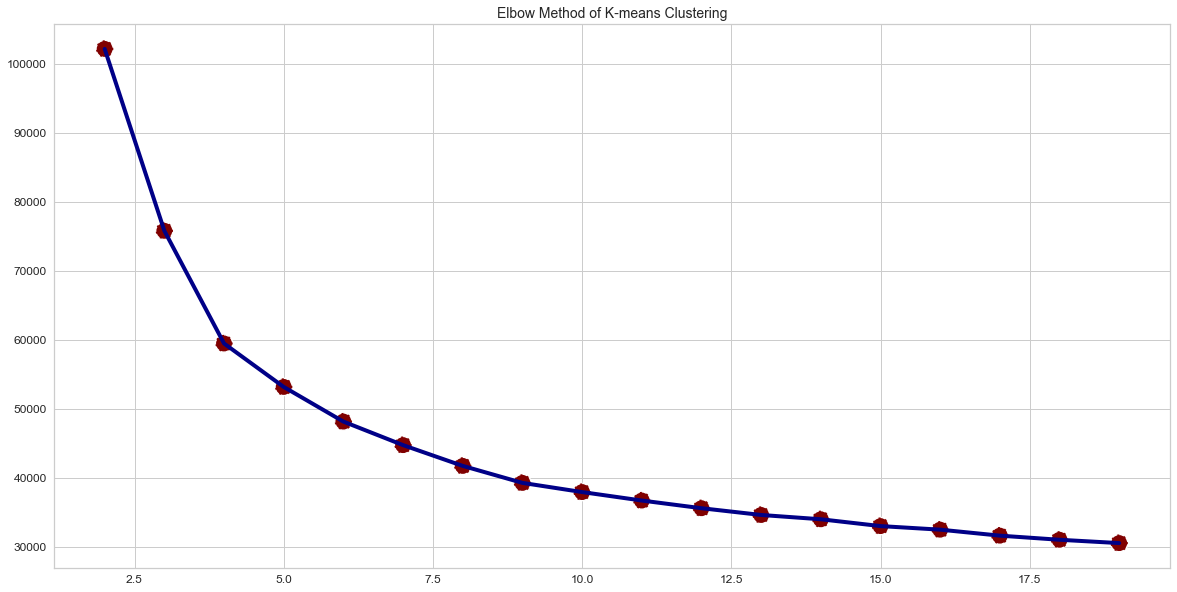

In [31]:
score = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X.values)
    score.append(kmeans.inertia_)

print(score)
plt.figure(figsize=(20, 10))
plt.title('Elbow Method of K-means Clustering')
# plt.plot(inertia)

sns.lineplot(x=range(2, 20), y=score, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 20), y=score, s=300, color='#800000',  linestyle='--')

In [32]:
# elbow score plot with Yellowbrick
def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2, nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  

  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):
elbow value = optimal k: 4  | elbow score: 59,450.197


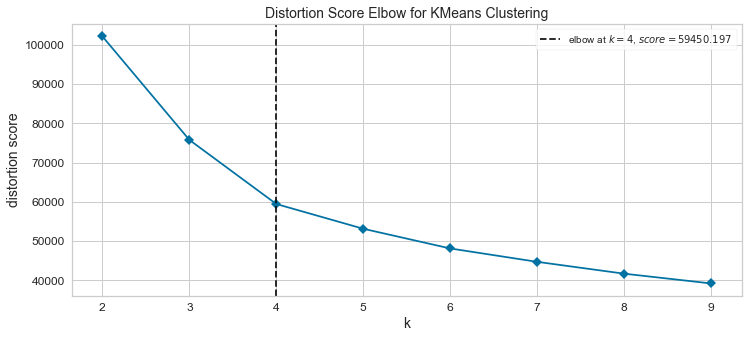

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.476


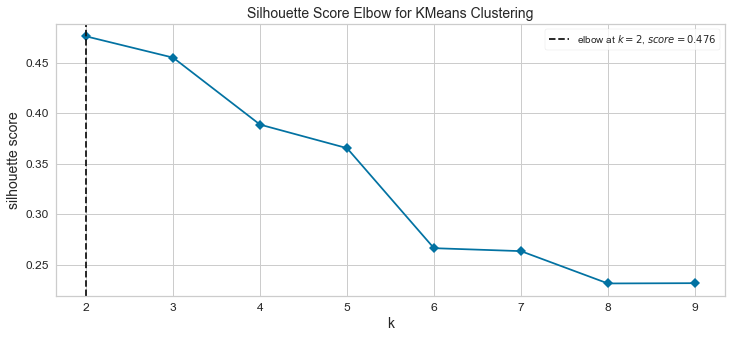

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 2  | elbow score: 2,722.488


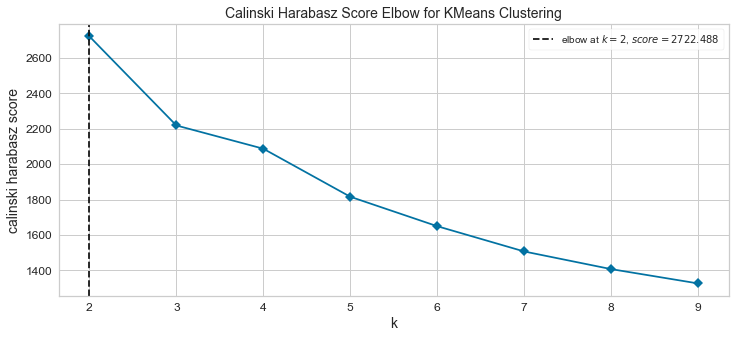

In [33]:
model = KMeans(random_state=SEED)
_ = [elbowplot(X, m, model) for m in tqdm(["distortion", "silhouette", "calinski_harabasz"])]

inertia scores (sum of squared errors) by number of clusters:
2 : 102,157
3 : 75,786
4 : 59,450
5 : 53,146
6 : 48,128
7 : 44,720
8 : 41,704
9 : 39,217


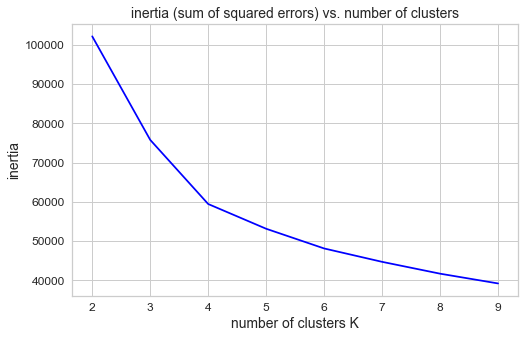

In [34]:
# kmeans: looking for the elbow - compare number of clusters by their inertia scores
# run kMeans for alternative number of clusters k
inertia_scores = [KMeans(
                    n_clusters=k, 
                    init='k-means++', 
                    n_init=10, max_iter=100, random_state=SEED). \
                    fit(X).inertia_ \
                    for k in range(2,nK)]


dict_inertia = dict(zip(range(2,nK), inertia_scores))
print("inertia scores (sum of squared errors) by number of clusters:")
_ = [print(k, ":", f'{v:,.0f}') for k,v in dict_inertia.items()]

# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(range(2,nK), inertia_scores, color="blue")
plt.title("inertia (sum of squared errors) vs. number of clusters")
plt.xticks(np.arange(2,nK,1.0))
plt.xlabel("number of clusters K")
plt.ylabel("inertia");

# Task 4 - Customer Personality Analysis for Marketing Retargeting

**Tahapan Pengerjaan**
1. Melakukan interpretasi terhadap hasil cluster yang ada dari masing-masing feature yang digunakan
2. Memilih cluster yang akan dilakukan marketing retargetting
3. Menghitung potential impact dari hasil marketing retargetting dari cluster yang ada

In [35]:
model = KMeans(n_clusters=4, random_state=SEED)
result = model.fit(X.values)
X['cluster'] = model.labels_
X.insert(0, 'cluster', X.pop('cluster'))
df_sum['cluster'] = model.labels_
df_sum.insert(0, 'cluster', df_sum.pop('cluster'))

In [36]:
X.head()

,cluster,age,income,kidhome,teenhome,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,response,join_at_age,total_children,is_parents,total_spent,total_accepted_camp,total_transaction,cvr
0,2,0.986443,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,0.351713,1.428553,2.504712,-0.554143,0.693232,0,0,0,0,0,0,1,0.897752,-1.264803,0,1.675488,0,25,3.571429
1,1,1.236801,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,-0.168231,-1.125881,-0.571082,-1.169518,-0.131574,0,0,0,0,0,0,0,1.313688,1.405806,1,-0.962358,0,6,1.200000
2,2,0.318822,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,-0.688176,1.428553,-0.229327,1.291982,-0.543978,0,0,0,0,0,0,0,0.315443,-1.264803,0,0.280250,0,21,5.250000
3,1,-1.266777,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,-0.168231,-0.760962,-0.912837,-0.554143,0.280829,0,0,0,0,0,0,0,-1.181925,0.070501,1,-0.919224,0,8,1.333333
4,3,-1.016420,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,1.391603,0.333796,0.112428,0.061232,-0.131574,0,0,0,0,0,0,0,-0.932363,0.070501,1,-0.307044,0,19,3.800000


In [37]:
X['cluster'].value_counts()

1    930
3    607
2    542
0    137
Name: cluster, dtype: int64

In [42]:
df_sum.head()

,cluster,id,year_birth,age,map_age,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,join_at_age,total_children,is_parents,total_spent,total_accepted_camp,total_transaction,cvr
0,2,5524,1957,65,5,3,6,58138000.0,0,0,2012-04-09,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1,55,0,0,1617000,0,25,3.571429
1,1,2174,1954,68,5,3,6,46344000.0,1,1,2014-08-03,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0,60,2,1,27000,0,6,1.200000
2,2,4141,1965,57,5,3,6,71613000.0,0,0,2013-08-21,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0,48,0,0,776000,0,21,5.250000
3,1,6182,1984,38,4,3,6,26646000.0,1,0,2014-10-02,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0,30,1,1,53000,0,8,1.333333
4,3,5324,1981,41,4,5,6,58293000.0,1,0,2014-01-19,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0,33,1,1,422000,0,19,3.800000


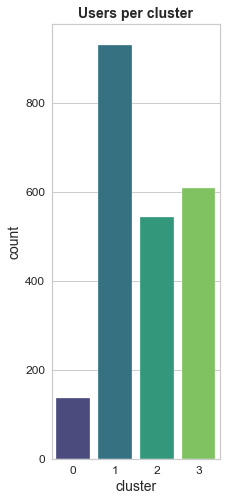

In [39]:
plt.figure(figsize=(3, 8))
sns.countplot(x=X['cluster'], palette='viridis')
plt.title('Users per cluster', fontweight='bold')
plt.show()

In [62]:
# helper function: medians and modes for each cluster
def cluster_profile(df):
    dfc = df.groupby('cluster').agg({
        'age': 'mean',
        'income': 'median',
        'num_deals_purchases': 'sum',
        'total_transaction': 'sum',
        'total_spent': 'median',
        'cvr': 'mean',
        'is_parents': lambda x: x.value_counts().index[0]
                                    })

    return dfc

In [63]:
cluster_profile(df_sum).T.round(1)

cluster,0,1,2,3
age,55.3,50.6,55.4,54.7
income,80124000.0,33516500.0,68130000.0,57906000.0
num_deals_purchases,140.0,1689.0,1598.0,1722.0
total_transaction,2661.0,6683.0,13384.0,10248.0
total_spent,1216000.0,58000.0,1116000.0,527000.0
cvr,19.4,1.3,6.4,4.0
is_parents,0.0,1.0,1.0,1.0


In [61]:
map_cluster = {
    0 : 'High Spender',
    1 : 'Risk of Churn',
    2 : 'Middle Spender',
    3 : 'Low Spender'
}

df_sum['cluster_mapped'] = df_sum['cluster'].map(map_cluster)

Text(0.5, 1.0, 'Total Income per Cluster')

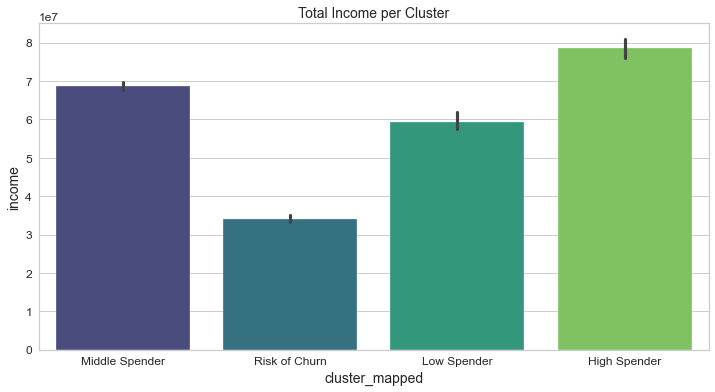

In [67]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df_sum['cluster_mapped'], y=df_sum['income'], palette='viridis')
plt.title('Total Income per Cluster')

Text(0.5, 1.0, 'Conversion Rate per Cluster')

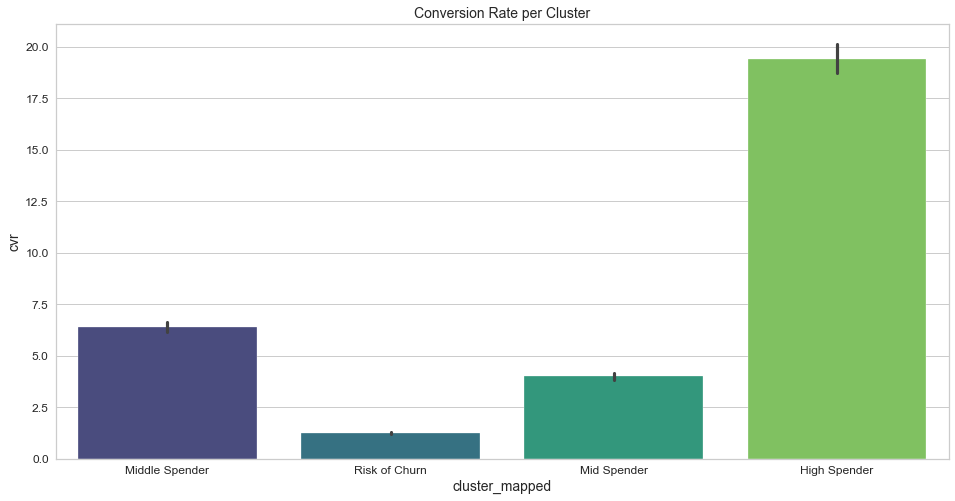

In [56]:
plt.figure(figsize=(16, 8))
sns.barplot(x=df_sum['cluster_mapped'], y=df_sum['cvr'], palette='viridis')
plt.title('Conversion Rate per Cluster')

Text(0.5, 1.0, 'Total Deals Purchases per Cluster')

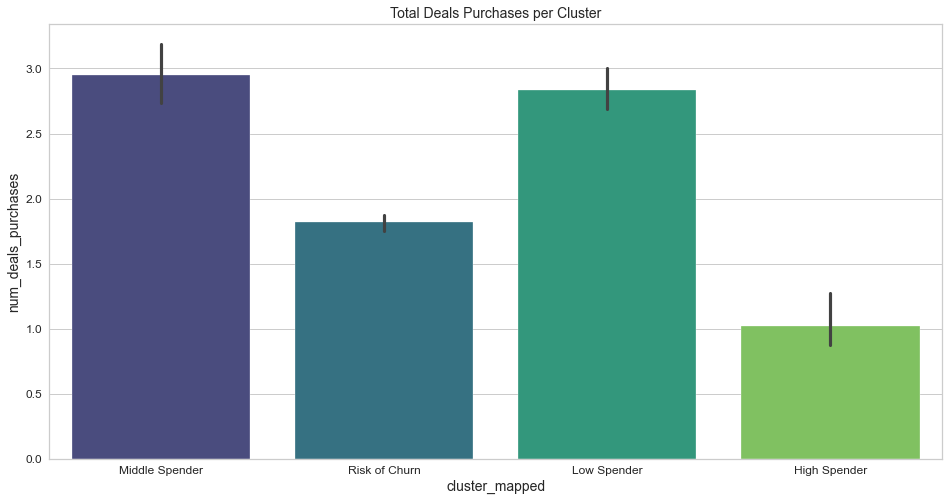

In [66]:
plt.figure(figsize=(16, 8))
sns.barplot(x=df_sum['cluster_mapped'], y=df_sum['num_deals_purchases'], palette='viridis')
plt.title('Total Deals Purchases per Cluster')

Text(0.5, 1.0, 'Total Spent per Cluster')

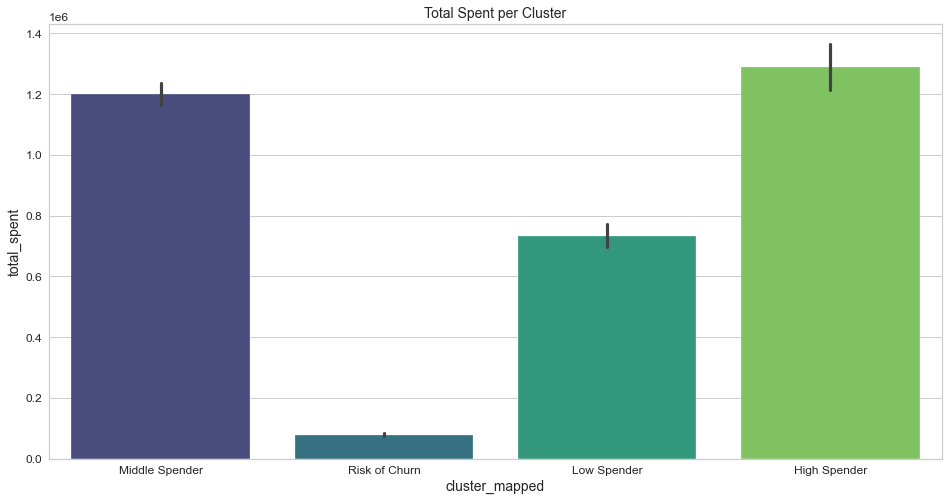

In [68]:
plt.figure(figsize=(16, 8))
sns.barplot(x=df_sum['cluster_mapped'], y=df_sum['total_spent'], palette='viridis')
plt.title('Total Spent per Cluster')

**INSIGHT**

**Low Spender**
- This group is dominated by parents with their average age being 54,7
- this group has the second smallest income and expenses

**Risk of Churn**
- This group is dominated by parents with their average age being 50,6
- This group also has the smallest income among other groups

**Middle Spender**
- This group is dominated by parents with their average age being 55,4
- This group also has the second highest expenditure after the high spender group

**High Spender**
- This group is dominated by parents with their average age being 55,3
- This group has highest income among other groups and also has highest conversion rate